## KEYS

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import scipy
from scipy import stats
stats.junk = lambda chisq, df: stats.chi2.sf(chisq, df)
import csv
import gffpandas.gffpandas as gffpd

CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
total = CC2344 + CC2931
genes = ['CC2344.resSig_L1.genes', 'CC2344.resSig_L2.genes', 'CC2344.resSig_L3.genes', 'CC2344.resSig_L4.genes',
           'CC2344.resSig_L5.genes', 'CC2344.resSig_L6.genes', 'CC2344.resSig_L7.genes', 'CC2344.resSig_L8.genes',
           'CC2344.resSig_L9.genes', 'CC2344.resSig_L10.genes', 'CC2344.resSig_L11.genes', 'CC2344.resSig_L12.genes',
           'CC2344.resSig_L13.genes', 'CC2344.resSig_L14.genes', 'CC2344.resSig_L15.genes', 'CC2931.resSig_L1.genes',
           'CC2931.resSig_L2.genes', 'CC2931.resSig_L3.genes', 'CC2931.resSig_L4.genes', 'CC2931.resSig_L5.genes',
           'CC2931.resSig_L6.genes', 'CC2931.resSig_L7.genes', 'CC2931.resSig_L9.genes', 'CC2931.resSig_L10.genes',
           'CC2931.resSig_L11.genes', 'CC2931.resSig_L13.genes', 'CC2931.resSig_L14.genes', 'CC2931.resSig_L15.genes']
dic = {genes[i]:total[i] for i in range(len(genes))}

def make_sorter(l):
    """
    Create a dict from the list to map to 0..len(l)
    Returns a mapper to map a series to this custom sort order
    """
    sort_order = {k:v for k,v in zip(l, range(len(l)))}
    return lambda s: s.map(lambda x: sort_order[x])

### COMBINING ALL DEGS INTO THE SAME  DATAFRAME

In [2]:
# ###############################################
# # COMBINING ALL DEGs INTO THE SAME DATAFRAME ##
# ###############################################

# adj_pval = pd.DataFrame()

# genes = ['CC2344.resSig_L1.genes', 'CC2344.resSig_L2.genes', 'CC2344.resSig_L3.genes', 'CC2344.resSig_L4.genes',
#            'CC2344.resSig_L5.genes', 'CC2344.resSig_L6.genes', 'CC2344.resSig_L7.genes', 'CC2344.resSig_L8.genes',
#            'CC2344.resSig_L9.genes', 'CC2344.resSig_L10.genes', 'CC2344.resSig_L11.genes', 'CC2344.resSig_L12.genes',
#            'CC2344.resSig_L13.genes', 'CC2344.resSig_L14.genes', 'CC2344.resSig_L15.genes', 'CC2931.resSig_L1.genes',
#            'CC2931.resSig_L2.genes', 'CC2931.resSig_L3.genes', 'CC2931.resSig_L4.genes', 'CC2931.resSig_L5.genes',
#            'CC2931.resSig_L6.genes', 'CC2931.resSig_L7.genes', 'CC2931.resSig_L9.genes', 'CC2931.resSig_L10.genes',
#            'CC2931.resSig_L11.genes', 'CC2931.resSig_L13.genes', 'CC2931.resSig_L14.genes', 'CC2931.resSig_L15.genes']

# for i in genes:
#     loc = '/research/projects/chlamydomonas/MAexpression/analysis/DEGs/degs/' + i
#     DF = pd.read_csv(loc, delimiter = ",")
#     DF[[i]] = DF[['Unnamed: 0']]
#     adj_pval = pd.concat([adj_pval, DF[i]], axis = 1)
#     adj_pval[i] = adj_pval[i].fillna('')

# adj_pval.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv', header = True, index = False)

# ####################################
# # ISOLATING THE LOCATIONS OF DEGs ##
# ####################################

# annotation = gffpd.read_gff3('/research/projects/chlamydomonas/MAexpression/data/genome_info/v6_genome_plus_anno/CC4532.v1_1.genes.primaryTrs.gff3')
# annotation_df = annotation.df
# annotation_df['attributes'] = annotation_df['attributes'].str.split(';', expand = True)

# total_genes = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv')

# CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
# CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
# list_noANC = CC2344[1:] + CC2931[1:]
# dic = {list_noANC[i]:genes[i] for i in range(len(genes))}

# for i in genes:
#     gene_list = total_genes[i].values.tolist()
#     gene_list = [x for x in gene_list if pd.isnull(x) == False]
#     feature_by_attribute = annotation.get_feature_by_attribute('ID', gene_list)
#     feature_by_attribute.to_csv(i + '.csv')

### IDENTIFYING HIGH AND LOW EXPRESSION GENES

In [2]:
#### OPENING FILES ####
CC2344_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t', index_col = 'index')
CC2931_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t', index_col = 'index')

#### 10TH PERCENTILE - LOW EXPRESSION GENES ####
CC2931_ANC_10 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 10)
CC2344_ANC_10 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 10)

#### 90TH PERCENTILE - HIGH EXPRESSION GENES ####
CC2931_ANC_90 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 90)
CC2344_ANC_90 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 90)

#### ISOLATING HIGH/LOW EXPRESSION GENES IN ANCESTRAL LINES ####
CC2931_hi_exp = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm['CC2931-ANC'] >= CC2931_ANC_90].index.values)
CC2931_low_exp = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm['CC2931-ANC'] <= CC2931_ANC_10].index.values)

CC2344_hi_exp = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm['CC2344-ANC'] >= CC2344_ANC_90].index.values)
CC2344_low_exp = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm['CC2344-ANC'] <= CC2344_ANC_10].index.values)

#### ISOLATING HIGH/LOW EXPRESSION GENES IN MA LINES #####
HL_MAgenes = {}
for i in CC2344 + CC2931:
    if 'CC2344' in i:
        HL_MAgenes[i + "_low"] = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm[i] <= CC2344_ANC_10].index.values)
        HL_MAgenes[i + "_hi"] = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm[i] >= CC2344_ANC_90].index.values)
    if 'CC2931' in i:
        HL_MAgenes[i + "_low"] = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm[i] <= CC2931_ANC_10].index.values)
        HL_MAgenes[i + "_hi"] = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm[i] >= CC2931_ANC_90].index.values)

### EXPRESSION LEVELS OF DEGs

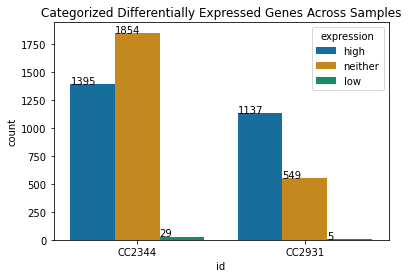

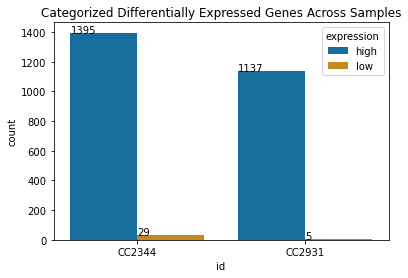

In [5]:
######################################
## EVALUATING EXPRESSION OF DEGs_v6 ##
######################################
DEGs_v6 = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv')
DEGs_v6 = pd.melt(DEGs_v6, value_vars = genes)
DEGs_v6.dropna(subset = ['value'], inplace=True)
DEGs_v6['id'] = 'nan'
DEGs_v6['expression'] = 'neither'

for i in list(DEGs_v6.index.values):
    if 'CC2344' in dic[DEGs_v6.at[i, 'variable']]:
        DEGs_v6.at[i, 'id'] = 'CC2344'
        DEGs_v6.at[i, 'sample'] = dic[DEGs_v6.at[i, 'variable']]
        if DEGs_v6.at[i, 'value'] in HL_MAgenes[DEGs_v6.at[i, 'sample'] + "_low"]:
            DEGs_v6.at[i, 'expression'] = 'low'
        if DEGs_v6.at[i, 'value'] in HL_MAgenes[DEGs_v6.at[i, 'sample'] + "_hi"]:
            DEGs_v6.at[i, 'expression'] = 'high'
    else:
        DEGs_v6.at[i, 'id'] = 'CC2931'
        DEGs_v6.at[i, 'sample'] = dic[DEGs_v6.at[i, 'variable']]
        if DEGs_v6.at[i, 'value'] in HL_MAgenes[DEGs_v6.at[i, 'sample'] + "_low"]:
            DEGs_v6.at[i, 'expression'] = 'low'
        if DEGs_v6.at[i, 'value'] in HL_MAgenes[DEGs_v6.at[i, 'sample'] + "_hi"]:
            DEGs_v6.at[i, 'expression'] = 'high'
            
DEGs_v6_no_neither = DEGs_v6.loc[DEGs_v6['expression'].isin(['high', 'low'])]

#### GRAPH OF CATEGORIZED DEGs ####
g = sns.countplot(data = DEGs_v6, x = 'id', hue = 'expression', palette = sns.color_palette('colorblind'))
for p in g.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.text(txt_x,txt_y,txt)
g.set_title('Categorized Differentially Expressed Genes Across Samples')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/categorized_DEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### GRAPH OF CATEGORIZED DEGs without NEITHER ####
plt.figure()
ax = sns.countplot(data = DEGs_v6_no_neither, x = 'id', hue = 'expression', palette = sns.color_palette('colorblind'))
for p in ax.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)
ax.set_title('Categorized Differentially Expressed Genes Across Samples')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/categorized_DEGs_without_neither.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### DEGs GENES ANNOTATION

In [6]:
#### OPENING FILES ####
UNIPROT = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/annotation_package/edited_anno/UNIPROT_BY_GENENAME', delimiter = '\t')
geneID = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/v5_to_v6_liftover/preliminary_v6_Cre_liftover.tsv', delimiter = '\t', header = None)
geneID.columns = ['v6', 'v5']
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv')
DEGs_v5 = {}

#### CONVERTING DEGs_v6 to DEGs_v5 #####
for i in genes:
    gene = DEGs[i].dropna()
    equivalent_v5 = geneID.loc[geneID['v6'].isin(gene.values.tolist())]
    DEGs_v5[dic[i]] = equivalent_v5['v5'].values.tolist()
DEGs_v5 = pd.DataFrame({ key:pd.Series(value) for key, value in DEGs_v5.items() })

##################################################
## CONVERTING HIGH/LOW EXPRESSION DEGs_v6 to v5 ##
##################################################
#### CC2344 #####
CC2344_DEGs = DEGs_v6_no_neither.loc[DEGs_v6_no_neither['id'] == 'CC2344']
CC2344_DEGs_HIGH = CC2344_DEGs.loc[CC2344_DEGs['expression'] == 'high']
CC2344_DEGs_LOW = CC2344_DEGs.loc[CC2344_DEGs['expression'] == 'low']
CC2344_DEGs_HIGH_v6 = geneID.loc[geneID['v6'].isin(CC2344_DEGs_HIGH['value'].values.tolist())]
CC2344_DEGs_LOW_v6 = geneID.loc[geneID['v6'].isin(CC2344_DEGs_LOW['value'].values.tolist())]
CC2344_DEGs_HIGH_v5 = CC2344_DEGs_HIGH_v6['v5'].values.tolist()
CC2344_DEGs_LOW_v5 = CC2344_DEGs_LOW_v6['v5'].values.tolist()
#### CC2931 ####
CC2931_DEGs_HL = DEGs_v6_no_neither.loc[DEGs_v6_no_neither['id'] == 'CC2931']
CC2931_DEGs_HIGH = CC2931_DEGs_HL.loc[CC2931_DEGs_HL['expression'] == 'high']
CC2931_DEGs_LOW = CC2931_DEGs_HL.loc[CC2931_DEGs_HL['expression'] == 'low']
CC2931_DEGs_HIGH_v6 = geneID.loc[geneID['v6'].isin(CC2931_DEGs_HIGH['value'].values.tolist())]
CC2931_DEGs_LOW_v6 = geneID.loc[geneID['v6'].isin(CC2931_DEGs_LOW['value'].values.tolist())]
CC2931_DEGs_HIGH_v5 = CC2931_DEGs_HIGH_v6['v5'].values.tolist()
CC2931_DEGs_LOW_v5 = CC2931_DEGs_LOW_v6['v5'].values.tolist()

#####################################################
## CONVERTING DEGs_v5 from "Cre" format to "CHLRE" ##
#####################################################

# edited_DEGs_v5 = DEGs_v5.replace({'Cre':'CHLRE_', '.g':'G'}, regex = True)
# edited_DEGs_v5['ending'] = 'V5'
# for i in edited_DEGs_v5.columns:
#     edited_DEGs_v5[i] = edited_DEGs_v5[i] + edited_DEGs_v5['ending']
# del edited_DEGs_v5['ending']

#### GENE ANNOTATION - CHROMID ####
GENEID = {}
GENEID_1 = {}
for i in CC2344:
#     gene = edited_DEGs_v5[i].dropna().values.tolist()
    gene = DEGs_v5[i].dropna().values.tolist()
    GENEID[i] = gene
GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
GENEID_DF.to_csv('DEGs/sortedby_chromid/CC2344_DEGs_allsamples.txt', sep = ',', index = False, header = True)
    
for i in CC2931:
#     gene_1 = edited_DEGs_v5[i].dropna().values.tolist()
    gene_1 = DEGs_v5[i].dropna().values.tolist()
    GENEID_1[i] = gene_1
GENEID_DF_1 = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID_1.items() })
GENEID_DF_1.to_csv('DEGs/sortedby_chromid/CC2931_DEGs_allsamples.txt', sep = ',', index = False, header = True)

# ##############################
# ## GENE ANNOTATION - GENEID ##
# ##############################
# GENEID = {}
# UNIPROT_GENENAME = UNIPROT['GENENAME'].values.tolist()
# gene_intersect = list(set.intersection(set(CC2344_DEGs_HIGH_v5), set(UNIPROT_GENENAME)))
# specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
# geneid = specific_genes['GENEID'].values.tolist()
# GENEID['CC2344_DEGs_HIGH_EXP'] = geneid
# GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2344_DEGs_high_expression.txt', sep = ',', index = False, header = True)

# GENEID = {}
# gene_intersect = list(set.intersection(set(CC2344_DEGs_LOW_v5), set(UNIPROT_GENENAME)))
# specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
# geneid = specific_genes['GENEID'].values.tolist()
# GENEID['CC2344_DEGs_LOW_EXP'] = geneid
# GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2344_DEGs_low_expression.txt', sep = ',', index = False, header = True)

# GENEID = {}
# gene_intersect = list(set.intersection(set(CC2931_DEGs_HIGH_v5), set(UNIPROT_GENENAME)))
# specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
# geneid = specific_genes['GENEID'].values.tolist()
# GENEID['CC2931_DEGs_HIGH_EXP'] = geneid
# GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2931_DEGs_high_expression.txt', sep = ',', index = False, header = True)

# GENEID = {}
# gene_intersect = list(set.intersection(set(CC2931_DEGs_LOW_v5), set(UNIPROT_GENENAME)))
# specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
# geneid = specific_genes['GENEID'].values.tolist()
# GENEID['CC2931_DEGs_LOW_EXP'] = geneid
# GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2931_DEGs_low_expression.txt', sep = ',', index = False, header = True)

# GENEID = {}
# GENEID_1 = {}

# for i in CC2344:
#     gene = DEGs_v5[i].dropna().values.tolist()
#     UNIPROT_GENENAME = UNIPROT['GENENAME'].values.tolist()
#     gene_intersect = list(set.intersection(set(gene), set(UNIPROT_GENENAME)))
#     specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
#     geneid = specific_genes['GENEID'].values.tolist()
#     GENEID[i] = geneid
# GENEID_DF = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID.items() })
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2344_DEGs_allsamples.txt', sep = ',', index = False, header = True)

# CC2344_list = []
# for i in CC2344:
#     gene = DEGs_v5[i].dropna().values.tolist()
#     UNIPROT_GENENAME = UNIPROT['GENENAME'].values.tolist()
#     gene_intersect = list(set.intersection(set(gene), set(UNIPROT_GENENAME)))
#     specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
#     geneid = specific_genes['GENEID'].values.tolist()
#     GENEID[i] = geneid
#     item = GENEID[i]
#     CC2344_list += item
# GENEID_DF = pd.DataFrame({'CC2344_combined_1':CC2344_list})
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2344_DEGs_allsamples_edited.txt', sep = ',', index = False, header = True)
    
# for i in CC2931:
#     gene_1 = DEGs_v5[i].dropna().values.tolist()
#     UNIPROT_GENENAME_1 = UNIPROT['GENENAME'].values.tolist()
#     gene_intersect_1 = list(set.intersection(set(gene_1), set(UNIPROT_GENENAME_1)))
#     specific_genes_1 = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect_1)]
#     geneid_1 = specific_genes_1['GENEID'].values.tolist()
#     GENEID_1[i] = geneid_1
# GENEID_DF_1 = pd.DataFrame({ key:pd.Series(value) for key, value in GENEID_1.items() })
# GENEID_DF_1.to_csv('DEGs/sortedby_geneid/CC2931_DEGs_allsamples.txt', sep = ',', index = False, header = True)

# CC2931_list = []
# for i in CC2931:
#     gene = DEGs_v5[i].dropna().values.tolist()
#     UNIPROT_GENENAME = UNIPROT['GENENAME'].values.tolist()
#     gene_intersect = list(set.intersection(set(gene), set(UNIPROT_GENENAME)))
#     specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
#     geneid = specific_genes['GENEID'].values.tolist()
#     GENEID[i] = geneid
#     item = GENEID[i]
#     CC2931_list += item
# GENEID_DF = pd.DataFrame({'CC2931_combined_1':CC2931_list})
# GENEID_DF.to_csv('DEGs/sortedby_geneid/CC2931_DEGs_allsamples_edited.txt', sep = ',', index = False, header = True)

# ####################################################################
# ## EXPORTING HIGH AND LOW EXPRESSION GENEID FOR CC2344 AND CC2931 ##
# ####################################################################
# gene = geneID.loc[geneID['v6'].isin(CC2344_low_exp)]
# gene_v5 = gene['v5'].values.tolist()
# selected_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_v5)]
# geneid = selected_genes['GENEID'].values.tolist()
# geneid = dict({'CC2344_LOW_EXPRESSION': geneid})
# geneid = pd.DataFrame.from_dict(geneid)
# geneid.to_csv('DEGs/sortedby_geneid/CC2344_low_expression_genes.txt', sep = ',', index = False, header = True)
                  
# gene = geneID.loc[geneID['v6'].isin(CC2931_low_exp)]
# gene_v5 = gene['v5'].values.tolist()
# selected_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_v5)]
# geneid = selected_genes['GENEID'].values.tolist()
# geneid = dict({'CC2931_LOW_EXPRESSION': geneid})
# geneid = pd.DataFrame.from_dict(geneid)
# geneid.to_csv('DEGs/sortedby_geneid/CC2931_low_expression_genes.txt', sep = ',', index = False, header = True)

# gene = geneID.loc[geneID['v6'].isin(CC2344_hi_exp)]
# gene_v5 = gene['v5'].values.tolist()
# selected_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_v5)]
# geneid = selected_genes['GENEID'].values.tolist()
# geneid = dict({'CC2344_HIGH_EXPRESSION': geneid})
# geneid = pd.DataFrame.from_dict(geneid)
# geneid.to_csv('DEGs/sortedby_geneid/CC2344_high_expression_genes.txt', sep = ',', index = False, header = True)

# gene = geneID.loc[geneID['v6'].isin(CC2931_hi_exp)]
# gene_v5 = gene['v5'].values.tolist()
# selected_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_v5)]
# geneid = selected_genes['GENEID'].values.tolist()
# geneid = dict({'CC2931_HIGH_EXPRESSION': geneid})
# geneid = pd.DataFrame.from_dict(geneid)
# geneid.to_csv('DEGs/sortedby_geneid/CC2931_high_expression_genes.txt', sep = ',', index = False, header = True)

### Cis Mutations

In [6]:
# ###################################################################
# ## CONVERTING GENEIDs DEGs_v6 to DEGs_v5 ##
# ###################################################################
# possible_cis = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/bin_10_to_400.csv', delimiter = '\t')[['seq_id', 'start', 'end', 'attributes', 'sample', 'bin_width', 'expression']]
# UNIPROT = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/annotation_package/edited_anno/UNIPROT_BY_GENENAME', delimiter = '\t')
# geneID = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/v5_to_v6_liftover/preliminary_v6_Cre_liftover.tsv', delimiter = '\t', header = None)
# geneID.columns = ['v6', 'v5']
# DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv')
# DEGs_v5 = {}
# possible_cis['v5'] = 'NaN'
# possible_cis['geneid'] = 'NaN'
# UNIPROT_GENENAME = UNIPROT['GENENAME'].values.tolist()

# for i in possible_cis.index.values:
#     gene = geneID.loc[geneID['v6'] == possible_cis.at[i, 'attributes']]
#     if gene['v6'].values.tolist() != []:
#         gene_v5 = gene['v5'].values.tolist()
#         possible_cis.at[i, 'v5'] = gene_v5[0]
#         if gene_v5[0] in UNIPROT_GENENAME:
#             UNIPROT_1 = UNIPROT.loc[UNIPROT['GENENAME'] == gene_v5[0]]
#             geneid = UNIPROT_1['GENEID'].values.tolist()
#             possible_cis.at[i, 'geneid'] = geneid[0]
# possible_cis.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/bin_10_to_400_wt_geneid', sep = '\t', index = False, header = True)

# geneid = possible_cis['geneid']
# geneid = geneid.replace('NaN', np.nan)
# geneid = geneid.dropna()
# geneid = [int(i) for i in geneid.values.tolist()]
# geneid = pd.DataFrame({'possible_cis': geneid})
# geneid.to_csv('DEGs/cis_mutations/GENEID.txt', sep = ',', index = False, header = True)

# possible_cis_chart = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/POSSIBLE_CIS_CHART.txt', delimiter = '\t')
# possible_cis = possible_cis.loc[possible_cis['geneid'].isin(possible_cis_chart['ID'])]
# possible_cis_HI = possible_cis.loc[possible_cis['expression'] == 'high']
# possible_cis_LO = possible_cis.loc[possible_cis['expression'] == 'low']
# possible_cis_chart_LO = possible_cis_chart.loc[possible_cis_chart['ID'].isin(possible_cis_LO['geneid'])][['Gene Name', 'GOTERM_BP_DIRECT', 'GOTERM_CC_DIRECT', 'GOTERM_MF_DIRECT', 'KEGG_PATHWAY']]
# possible_cis_chart_HI = possible_cis_chart.loc[possible_cis_chart['ID'].isin(possible_cis_HI['geneid'])][['Gene Name', 'GOTERM_BP_DIRECT', 'GOTERM_CC_DIRECT', 'GOTERM_MF_DIRECT', 'KEGG_PATHWAY']]
# possible_cis_chart_LO = possible_cis_chart_LO.astype(str)
# possible_cis_chart_HI = possible_cis_chart_HI.astype(str)

# ## AMENDMENT TO VALUE COLUMN
# for i in ['GOTERM_CC_DIRECT', 'GOTERM_BP_DIRECT', 'GOTERM_MF_DIRECT']:
#     if possible_cis_chart_LO[i].all() != 'nan':
#         possible_cis_chart_LO[i] = possible_cis_chart_LO[i].str.split(',', expand = True)[0]
#         possible_cis_chart_LO[i] = possible_cis_chart_LO[i].str.split('~', expand = True)[1]
#     if possible_cis_chart_HI[i].all() != 'nan':
#         possible_cis_chart_HI[i] = possible_cis_chart_HI[i].str.split(',', expand = True)[0]
#         possible_cis_chart_HI[i] = possible_cis_chart_HI[i].str.split('~', expand = True)[1]
    
# possible_cis_chart_HI['KEGG_PATHWAY'] = possible_cis_chart_HI['KEGG_PATHWAY'].str.split(':', expand = True)[1];
# possible_cis_chart_LO['KEGG_PATHWAY'] = possible_cis_chart_LO['KEGG_PATHWAY'].str.split(':', expand = True)

# possible_cis_chart_LO = pd.melt(possible_cis_chart_LO, id_vars=['Gene Name'], value_vars=['GOTERM_BP_DIRECT', 'GOTERM_MF_DIRECT', 'GOTERM_CC_DIRECT', 'KEGG_PATHWAY'])
# possible_cis_chart_HI = pd.melt(possible_cis_chart_HI, id_vars=['Gene Name'], value_vars=['GOTERM_BP_DIRECT', 'GOTERM_MF_DIRECT', 'GOTERM_CC_DIRECT', 'KEGG_PATHWAY'])
# possible_cis_chart_HI

### DEGs DAVID Annotation Clustering

In [10]:
#### OPENING DAVID ANNOTATION CLUSTERING ####
## missing DEGs with low expression for counts are too low
CC2344_AS_CLUSTERING = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_ALL_SAMPLES_CLUSTERING.txt', delimiter = '\t', skiprows = 1)
CC2931_AS_CLUSTERING = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_ALL_SAMPLES_CLUSTERING.txt', delimiter = '\t', skiprows = 1)

CC2344_HI_CLUSTERING = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_HIGH_EXP_CLUSTERING.txt', delimiter = '\t', skiprows = 1)
CC2931_HI_CLUSTERING = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_HIGH_EXP_CLUSTERING.txt', delimiter = '\t', skiprows = 1)

CC2344_LO_CLUSTERING = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_LOW_EXP_CLUSTERING.txt', delimiter = '\t', skiprows = 1)
CC2931_LO_CLUSTERING = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_LOW_EXP_CLUSTERING.txt', delimiter = '\t', skiprows = 1)

CC2344_DEGs_HI_CLUSTERING = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_DEGs_HIGH_CLUSTERING.txt', delimiter = '\t', skiprows = 1)
CC2931_DEGs_HI_CLUSTERING = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_DEGs_HIGH_CLUSTERING.txt', delimiter = '\t', skiprows = 1)

### DEGs DAVID Annotation Chart

In [14]:
#### OPENING DAVID ANNOTATION CHART ####
## missing DEGs with low expression for counts are too low
CC2344_AS = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_ALL_SAMPLES_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2931_AS = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_ALL_SAMPLES_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2344_HI = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_HIGH_EXP_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2931_HI = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_HIGH_EXP_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2344_LO = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_LOW_EXP_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2931_LO = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_LOW_EXP_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2344_DEGs_HI = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2344_DEGs_HIGH_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]
CC2931_DEGs_HI = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/CC2931_DEGs_HIGH_CHART.txt', delimiter = '\t')[['Category', 'Term', 'Count', '%', 'PValue']]

In [15]:
def david_anno(CC2344_HI, CC2931_HI, high):
    "'returns a dataframe containing the first five shared annotations across samples within a genotype and shared'"
    import pandas as pd
    
    CC2344_HI_KEGG = CC2344_HI.loc[CC2344_HI['Category'] == 'KEGG_PATHWAY']
    CC2344_HI_CC = CC2344_HI.loc[CC2344_HI['Category'] == 'GOTERM_CC_DIRECT']
    CC2344_HI_BP = CC2344_HI.loc[CC2344_HI['Category'] == 'GOTERM_BP_DIRECT']
    CC2344_HI_MF = CC2344_HI.loc[CC2344_HI['Category'] == 'GOTERM_MF_DIRECT']
    
    CC2931_HI_KEGG = CC2931_HI.loc[CC2931_HI['Category'] == 'KEGG_PATHWAY']
    CC2931_HI_CC = CC2931_HI.loc[CC2931_HI['Category'] == 'GOTERM_CC_DIRECT']
    CC2931_HI_BP = CC2931_HI.loc[CC2931_HI['Category'] == 'GOTERM_BP_DIRECT']
    CC2931_HI_MF = CC2931_HI.loc[CC2931_HI['Category'] == 'GOTERM_MF_DIRECT']

    ## CELLULAR COMPONENT (CC)
    CC2344_HI_CC = CC2344_HI_CC.sort_values(by = ['Count'], ascending = False)
    CC2344_HI_CC.reset_index(inplace = True)
    CC2344_HI_CC['Term'] = CC2344_HI_CC['Term'].str.split('~', expand = True)[1];
    
    CC2931_HI_CC = CC2931_HI_CC.sort_values(by = ['Count'], ascending = False)
    CC2931_HI_CC.reset_index(inplace = True)
    CC2931_HI_CC['Term'] = CC2931_HI_CC['Term'].str.split('~', expand = True)[1];

    ## BIOLOGICAL PROCESSES (BP)
    CC2344_HI_BP = CC2344_HI_BP.sort_values(by = ['Count'], ascending = False)
    CC2344_HI_BP.reset_index(inplace = True)
    CC2344_HI_BP['Term'] = CC2344_HI_BP['Term'].str.split('~', expand = True)[1];
    
    CC2931_HI_BP = CC2931_HI_BP.sort_values(by = ['Count'], ascending = False)
    CC2931_HI_BP.reset_index(inplace = True)
    CC2931_HI_BP['Term'] = CC2931_HI_BP['Term'].str.split('~', expand = True)[1];

    ## MOLECULAR FUNCTION (MF)
    CC2344_HI_MF = CC2344_HI_MF.sort_values(by = ['Count'], ascending = False)
    CC2344_HI_MF.reset_index(inplace = True)
    CC2344_HI_MF['Term'] = CC2344_HI_MF['Term'].str.split('~', expand = True)[1];
    
    CC2931_HI_MF = CC2931_HI_MF.sort_values(by = ['Count'], ascending = False)
    CC2931_HI_MF.reset_index(inplace = True)
    CC2931_HI_MF['Term'] = CC2931_HI_MF['Term'].str.split('~', expand = True)[1];

    ## KEGG PATHWAY (KEGG)
    if CC2344_HI_KEGG.values.tolist() != []:
        CC2344_HI_KEGG = CC2344_HI_KEGG.sort_values(by = ['Count'], ascending = False)
        CC2344_HI_KEGG.reset_index(inplace = True)
        CC2344_HI_KEGG['Term'] = CC2344_HI_KEGG['Term'].str.split(':', expand = True)[1];

    if CC2931_HI_KEGG.values.tolist() != []:
        CC2931_HI_KEGG = CC2931_HI_KEGG.sort_values(by = ['Count'], ascending = False)
        CC2931_HI_KEGG.reset_index(inplace = True)
        CC2931_HI_KEGG['Term'] = CC2931_HI_KEGG['Term'].str.split(':', expand = True)[1];

    terms_CC = list(set.intersection(set(CC2344_HI_CC.iloc[:5]['Term'].values.tolist()), set(CC2931_HI_CC.iloc[:5]['Term'].values.tolist())))
    terms_BP = list(set.intersection(set(CC2344_HI_BP.iloc[:5]['Term'].values.tolist()), set(CC2931_HI_BP.iloc[:5]['Term'].values.tolist())))
    terms_MF = list(set.intersection(set(CC2344_HI_MF.iloc[:5]['Term'].values.tolist()), set(CC2931_HI_MF.iloc[:5]['Term'].values.tolist())))
    terms_KEGG = list(set.intersection(set(CC2344_HI_KEGG.iloc[:5]['Term'].values.tolist()), set(CC2931_HI_KEGG.iloc[:5]['Term'].values.tolist())))

    ## COMPILATION
    HEGs_1 = pd.DataFrame(); CC2344_HEGs_1 = pd.DataFrame(); CC2931_HEGs_1 = pd.DataFrame(); HEGs_2 = pd.DataFrame(); CC2344_HEGs_2 = pd.DataFrame(); CC2931_HEGs_2 = pd.DataFrame(); HEGs_3 = pd.DataFrame(); CC2344_HEGs_3 = pd.DataFrame(); CC2931_HEGs_3 = pd.DataFrame(); HEGs_4 = pd.DataFrame(); CC2344_HEGs_4 = pd.DataFrame(); CC2931_HEGs_4 = pd.DataFrame();
    
    HEGs_1['terms'] = terms_MF
    col1 = CC2344_HI_MF.loc[CC2344_HI_MF['Term'].isin(terms_MF)]
    col2 = CC2931_HI_MF.loc[CC2931_HI_MF['Term'].isin(terms_MF)]
    col1 = col1.sort_values('Term', key=make_sorter(terms_MF))
    col2 = col2.sort_values('Term', key=make_sorter(terms_MF))
    HEGs_1['count'] = col1['Count'] + col2['Count']
    HEGs_1['sample'] = 'both'
    CC2344_HEGs_1['terms'] = CC2344_HI_MF.iloc[:5]['Term'].values.tolist()
    CC2344_HEGs_1['count'] = CC2344_HI_MF['Count'].iloc[:5]
    CC2931_HEGs_1['terms'] = CC2931_HI_MF.iloc[:5]['Term'].values.tolist()
    CC2931_HEGs_1['count'] = CC2931_HI_MF['Count'].iloc[:5]
    CC2344_HEGs_1['sample'] = 'CC2344'
    CC2931_HEGs_1['sample'] = 'CC2931'
    HEGs_1 = pd.concat([HEGs_1, CC2344_HEGs_1, CC2931_HEGs_1], axis = 0)
    HEGs_1['type'] = 'molecular function'

    HEGs_2['terms'] = terms_BP
    col1 = CC2344_HI_BP.loc[CC2344_HI_BP['Term'].isin(terms_BP)]
    col2 = CC2931_HI_BP.loc[CC2931_HI_BP['Term'].isin(terms_BP)]
    col1 = col1.sort_values('Term', key=make_sorter(terms_BP))
    col2 = col2.sort_values('Term', key=make_sorter(terms_BP))
    HEGs_2['count'] = col1['Count'] + col2['Count']
    HEGs_2['sample'] = 'both'
    CC2344_HEGs_2['terms'] = CC2344_HI_BP.iloc[:5]['Term'].values.tolist()
    CC2931_HEGs_2['terms'] = CC2931_HI_BP.iloc[:5]['Term'].values.tolist()
    CC2344_HEGs_2['count'] = CC2344_HI_BP['Count'].iloc[:5]
    CC2931_HEGs_2['count'] = CC2931_HI_BP['Count'].iloc[:5]
    CC2344_HEGs_2['sample'] = 'CC2344'
    CC2931_HEGs_2['sample'] = 'CC2931'
    HEGs_2 = pd.concat([HEGs_2, CC2344_HEGs_2, CC2931_HEGs_2], axis = 0)
    HEGs_2['type'] = 'biological processes'

    HEGs_3['terms'] = terms_CC
    col1 = CC2344_HI_CC.loc[CC2344_HI_CC['Term'].isin(terms_CC)]
    col2 = CC2931_HI_CC.loc[CC2931_HI_CC['Term'].isin(terms_CC)]
    col1 = col1.sort_values('Term', key=make_sorter(terms_CC))
    col2 = col2.sort_values('Term', key=make_sorter(terms_CC))
    HEGs_3['count'] = col1['Count'] + col2['Count']
    HEGs_3['sample'] = 'both'
    CC2344_HEGs_3['terms'] = CC2344_HI_CC.iloc[:5]['Term'].values.tolist()
    CC2931_HEGs_3['terms'] = CC2931_HI_CC.iloc[:5]['Term'].values.tolist()
    CC2344_HEGs_3['count'] = CC2344_HI_CC['Count'].iloc[:5]
    CC2931_HEGs_3['count'] = CC2931_HI_CC['Count'].iloc[:5]
    CC2344_HEGs_3['sample'] = 'CC2344'
    CC2931_HEGs_3['sample'] = 'CC2931'
    HEGs_3 = pd.concat([HEGs_3, CC2344_HEGs_3, CC2931_HEGs_3], axis = 0)
    HEGs_3['type'] = 'cellular component'

    HEGs_4['terms'] = terms_KEGG
    col1 = CC2344_HI_KEGG.loc[CC2344_HI_KEGG['Term'].isin(terms_KEGG)]
    col2 = CC2931_HI_KEGG.loc[CC2931_HI_KEGG['Term'].isin(terms_KEGG)]
    col1 = col1.sort_values('Term', key=make_sorter(terms_KEGG))
    col2 = col2.sort_values('Term', key=make_sorter(terms_KEGG))
    HEGs_4['count'] = col1['Count'] + col2['Count']
    HEGs_4['sample'] = 'both'
    CC2344_HEGs_4['terms'] = CC2344_HI_KEGG.iloc[:5]['Term'].values.tolist()
    CC2931_HEGs_4['terms'] = CC2931_HI_KEGG.iloc[:5]['Term'].values.tolist()
    CC2344_HEGs_4['count'] = CC2344_HI_KEGG['Count'].iloc[:5]
    CC2931_HEGs_4['count'] = CC2931_HI_KEGG['Count'].iloc[:5]
    CC2344_HEGs_4['sample'] = 'CC2344'
    CC2931_HEGs_4['sample'] = 'CC2931'
    HEGs_4 = pd.concat([HEGs_4, CC2344_HEGs_4, CC2931_HEGs_4], axis = 0)
    HEGs_4['type'] = 'kegg pathway'

    HEGs = pd.concat([HEGs_1, HEGs_2, HEGs_3, HEGs_4], axis = 0)
    HEGs['expression'] = high
    return HEGs

In [16]:
DEGs = david_anno(CC2344_AS, CC2931_AS, 'differential')
HEGs = david_anno(CC2344_HI, CC2931_HI, 'high')
LEGs = david_anno(CC2344_LO, CC2931_LO, 'low')
DEGs_HI = david_anno(CC2344_DEGs_HI, CC2931_DEGs_HI, 'high')

### DAVID ANNOTATION IMAGES

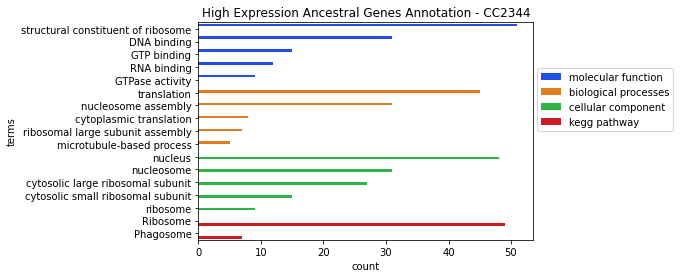

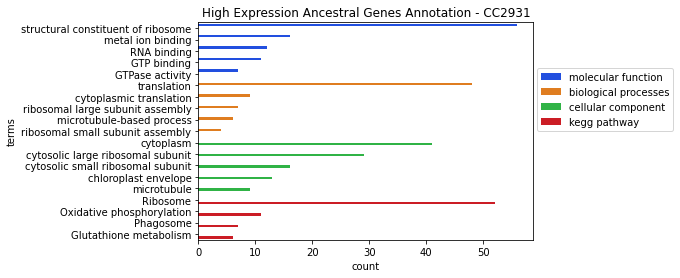

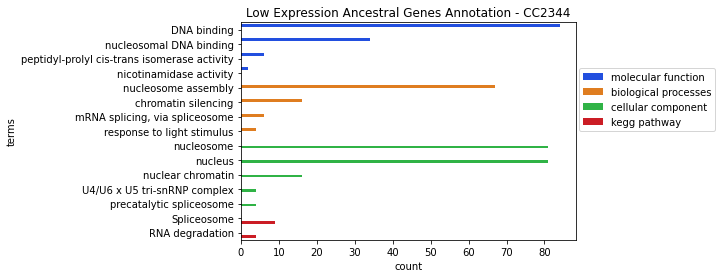

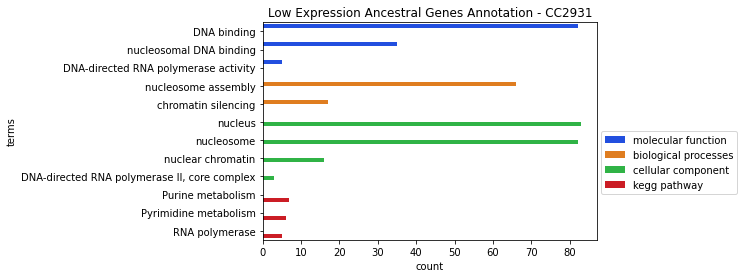

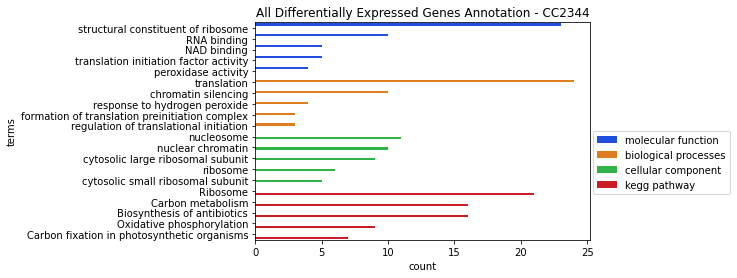

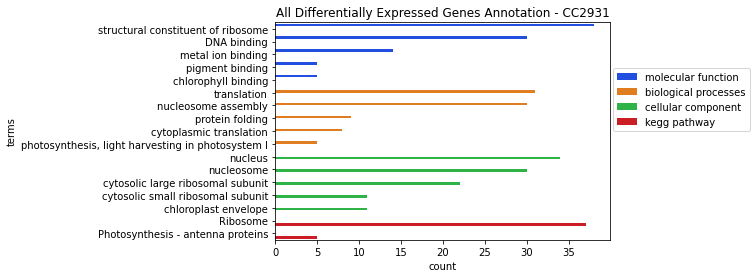

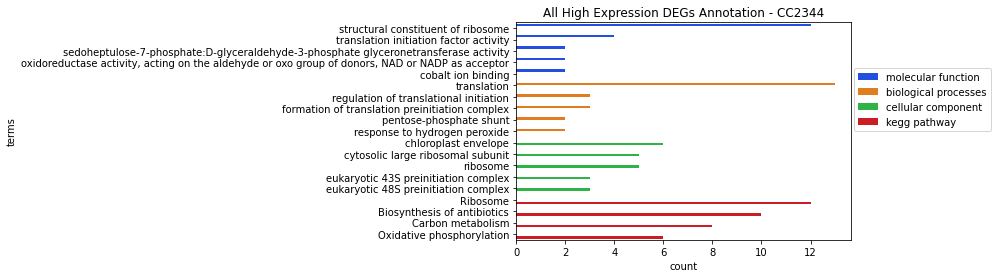

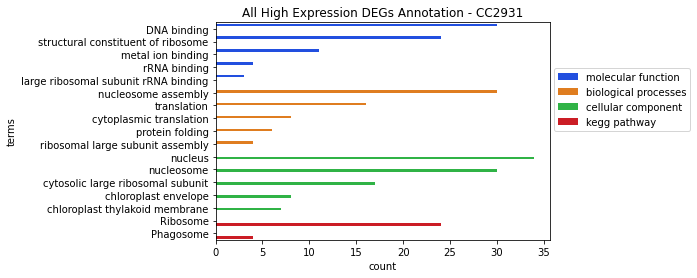

In [17]:
#### HIGH EXPRESSION GENES ####
a = sns.barplot(data = HEGs.loc[HEGs['sample'] == 'CC2344'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('High Expression Ancestral Genes Annotation - CC2344')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/high_expression_genes_CC2344.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
a = sns.barplot(data = HEGs.loc[HEGs['sample'] == 'CC2931'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('High Expression Ancestral Genes Annotation - CC2931')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/high_expression_genes_CC2931.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### LOW EXPRESSION GENES ####
plt.figure()
a = sns.barplot(data = LEGs.loc[LEGs['sample'] == 'CC2344'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('Low Expression Ancestral Genes Annotation - CC2344')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/low_expression_genes_CC2344.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
a = sns.barplot(data = LEGs.loc[LEGs['sample'] == 'CC2931'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('Low Expression Ancestral Genes Annotation - CC2931')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/low_expression_genes_CC2931.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### ALL DIFFERNTIALLY EXPRESSED GENES ####
plt.figure()
a = sns.barplot(data = DEGs.loc[DEGs['sample'] == 'CC2344'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('All Differentially Expressed Genes Annotation - CC2344')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/DEGs_allsamples_CC2344.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
a = sns.barplot(data = DEGs.loc[DEGs['sample'] == 'CC2931'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('All Differentially Expressed Genes Annotation - CC2931')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/DEGs_allsamples_CC2931.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### HIGH EXPRESSION DEGs ####
plt.figure()
a = sns.barplot(data = DEGs_HI.loc[DEGs_HI['sample'] == 'CC2344'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('All High Expression DEGs Annotation - CC2344')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/high_expression_DEGs_CC2344.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
a = sns.barplot(data = DEGs_HI.loc[DEGs_HI['sample'] == 'CC2931'], x = 'count', y = 'terms', hue = 'type', palette=sns.color_palette('bright'))
a.set_title('All High Expression DEGs Annotation - CC2931')
plt.legend(bbox_to_anchor=(1.01, 0.5), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/high_expression_DEGs_CC2931.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

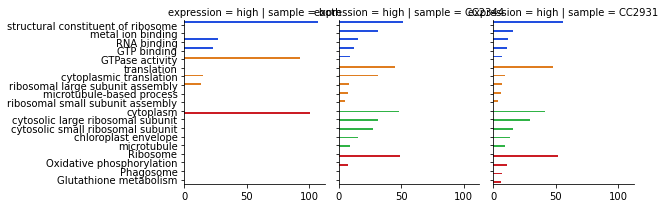

In [28]:
#### COMBINED ANNOTATION CHART ####
COMBINED = pd.concat([DEGs, HEGs, LEGs], axis = 0)
g = sns.FacetGrid(COMBINED, row = "expression", col = "sample", palette = 'Set1', margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
g.add_legend()
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/combined_anno_chart.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
COMBINED = pd.concat([DEGs, HEGs, LEGs], axis = 0)
sns.set_palette("RdBu")
e = sns.FacetGrid(COMBINED.loc[COMBINED['sample'] == 'CC2931'], row = "sample", col = "expression", palette = 'Set1', margin_titles=True)
e.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/combined_anno_chart_CC2931', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
COMBINED = pd.concat([DEGs, HEGs, LEGs], axis = 0)
sns.set_palette("RdBu")
e = sns.FacetGrid(COMBINED.loc[COMBINED['sample'] == 'CC2344'], row = "sample", col = "expression", palette = 'Set1', margin_titles=True)
e.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/combined_anno_chart_CC2344', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
g = sns.FacetGrid(DEGs_HI.loc[DEGs_HI['sample'].isin(['CC2344', 'CC2931'])], row = "sample", col = "expression", palette = 'Set1', margin_titles=True)
g.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
g.add_legend()
plt.xlabel('Counts')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/CC2931_CC2344_differentially_expressed_HEGs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
a = sns.FacetGrid(HEGs, row = "expression", col = "sample", palette = 'Set1')
a.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/combined_HEGs_anno_chart.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
b = sns.FacetGrid(LEGs, row = "expression", col = "sample", palette = 'Set1', margin_titles=True)
b.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/combined_LEGs_anno_chart.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
c = sns.FacetGrid(DEGs, row = "expression", col = "sample", palette = 'Set1', margin_titles=True)
c.map_dataframe(sns.barplot, x = "count", y = "terms", hue = 'type', palette=sns.color_palette('bright'))
plt.xlabel('Counts')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/DAVID_anno/images/combined_DEGs_anno_chart.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')